In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import NB_Funcs as hlp

In [3]:
def pickle_save(filename, data):
    with open(filename,'wb') as _save:
        pickle.dump(data,_save)
    
def pickle_load(filename):
    with open(filename,'rb') as _load:
        var = pickle.load(_load)
    return var

# Loading Data

In [4]:
#each variable in (colony_form_data, ring_form_data, plate_maximums) form
ACK_DF = pickle_load("../Pickles/Data/AC_K_PreprocessedData")
ACN_DF = pickle_load("../Pickles/Data/AC_N_PreprocessedData")
ACS_DF = pickle_load("../Pickles/Data/AC_S_PreprocessedData")
DIFF_DF = pickle_load("../Pickles/Data/Diffusion_PreprocessedData")

In [5]:
#ACK
K = np.load('../data/October/AC_K/autocorrelated_K_K_10_10_2022.npy')
N_K = np.load('../data/October/AC_K/autocorrelated_K_n_curves_10_10_2022.npy')
#ACN
N_N = np.load('../data/February/M_model_n_curves_02_02_2023.npy')
#ACS
S_S = np.load('../data/October/AC_S/autocorrelated_S_s_curves_10_10_2022.npy')
N_S = np.load('../data/October/AC_S/autocorrelated_S_n_curves_10_10_2022.npy')
#DIFF
N_D = np.load('../data/October/Diffusion/diffusion_S_n_curves_10_10_2022.npy')
S_D = np.load('../data/October/Diffusion/diffusion_S_s_curves_10_10_2022.npy')

In [17]:
trueACK = np.array([df['dNovN'] for i in range(len(ACK_DF[0][1])) for df in ACK_DF[0][1][i]]).reshape(32,48,250)

trueACN = np.array([df['dNovN'] for i in range(len(ACN_DF[0][1])) for df in ACN_DF[0][1][i]]).reshape(32,48,250)

trueACS = np.array([df['dNovN'] for i in range(len(ACS_DF[0][1])) for df in ACS_DF[0][1][i]]).reshape(32,48,400)

trueDIFF = np.array([df['dNovN'] for i in range(len(DIFF_DF[0][1])) for df in DIFF_DF[0][1][i]]).reshape(32,48,400)

In [18]:
N_K = N_K[:,:250,:,:]
N_N = N_N[:,:250,:,:]
time1 = np.arange(N_K.shape[1]) * 0.1
time2 = np.arange(N_S.shape[1]) * 0.1

In [29]:
dNdt_K = hlp.cubic_splines(N_K[1],time1); dNovN_K = dNdt_K / N_K[1]
dNdt_N = hlp.cubic_splines(N_N[1],time1); dNovN_N = dNdt_N / N_N[1]
dNdt_S = hlp.cubic_splines(N_S[1],time2); dNovN_S = dNdt_S / N_S[1]
dNdt_D = hlp.cubic_splines(N_D[1],time2); dNovN_D = dNdt_D / N_D[1]

In [30]:
dNovN_K.shape

(250, 32, 48)

In [53]:
meanACK = np.mean(dNovN_K,axis=(1,2))
meanACN = np.mean(dNovN_N,axis=(1,2))
meanACS = np.mean(dNovN_S,axis=(1,2))
meanDIFF = np.mean(dNovN_D,axis=(1,2))

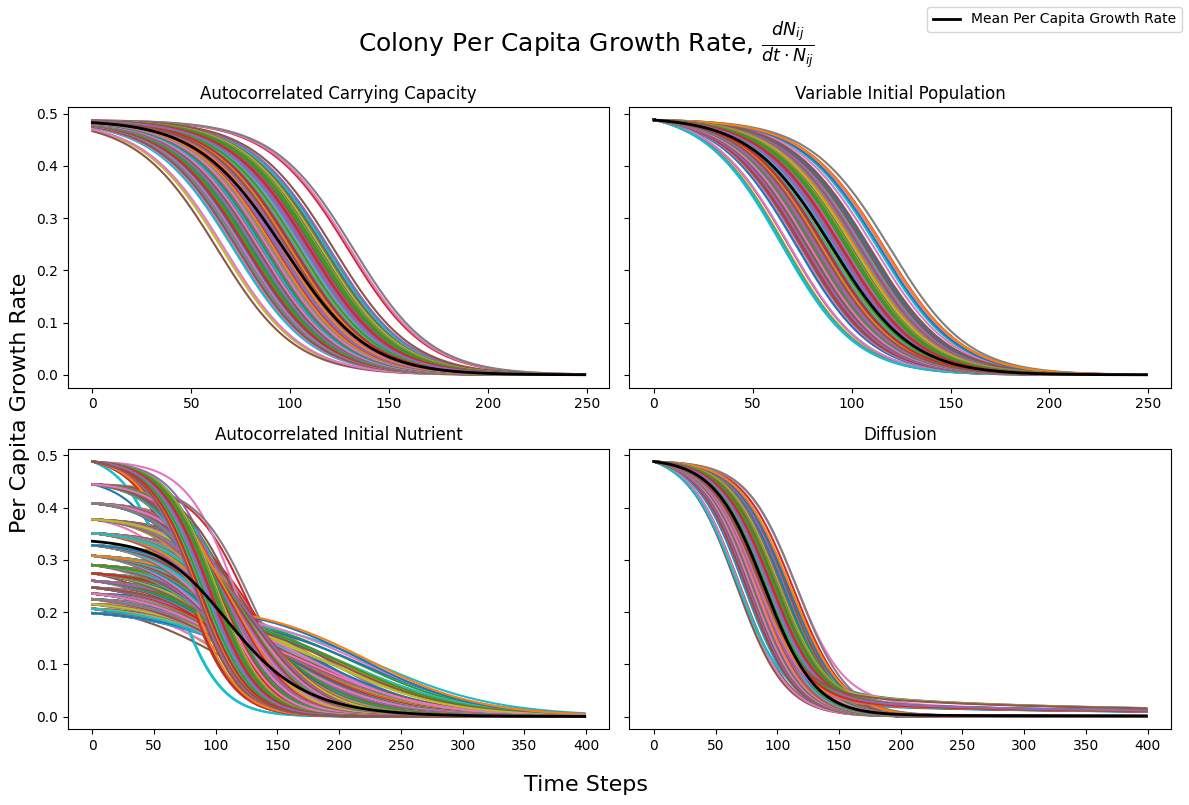

In [63]:
fig, axs = plt.subplots(2,2,figsize=(12,8),sharey=True)

for i in range(N_K.shape[2]):
    for j in range(N_K.shape[3]):
        axs[0][0].plot(dNovN_K[:,i,j]); axs[0][0].set_title("Autocorrelated Carrying Capacity")
        axs[0][1].plot(dNovN_N[:,i,j]); axs[0][1].set_title("Variable Initial Population")
        axs[1][0].plot(dNovN_S[:,i,j]); axs[1][0].set_title("Autocorrelated Initial Nutrient")
        axs[1][1].plot(dNovN_D[:,i,j]); axs[1][1].set_title("Diffusion")
        
# plot mean curves
axs[0][0].plot(meanACK,c='k',lw=2,label='Mean Per Capita Growth Rate')
axs[0][1].plot(meanACN,c='k',lw=2)
axs[1][0].plot(meanACS,c='k',lw=2)
axs[1][1].plot(meanDIFF,c='k',lw=2)

fig.supylabel("Per Capita Growth Rate",fontsize=16)
fig.supxlabel("Time Steps",fontsize=16)
fig.suptitle(r"Colony Per Capita Growth Rate, $\frac{dN_{ij}}{dt\cdot N_{ij}}$",fontsize=18)
fig.legend()
fig.tight_layout()
plt.show()

In [54]:
def Null_Model_Errors(true,mean):
    errs = np.zeros(true.shape)
    for i in range(true.shape[0]):
        for j in range(true.shape[1]):
            errs[i,j,:] = np.sqrt(np.square(mean-true[i,j,:]))
    return errs

In [55]:
NullE_K = Null_Model_Errors(trueACK,meanACK)
NullE_N = Null_Model_Errors(trueACN,meanACN)
NullE_S = Null_Model_Errors(trueACS,meanACS)
NullE_D = Null_Model_Errors(trueDIFF,meanDIFF)

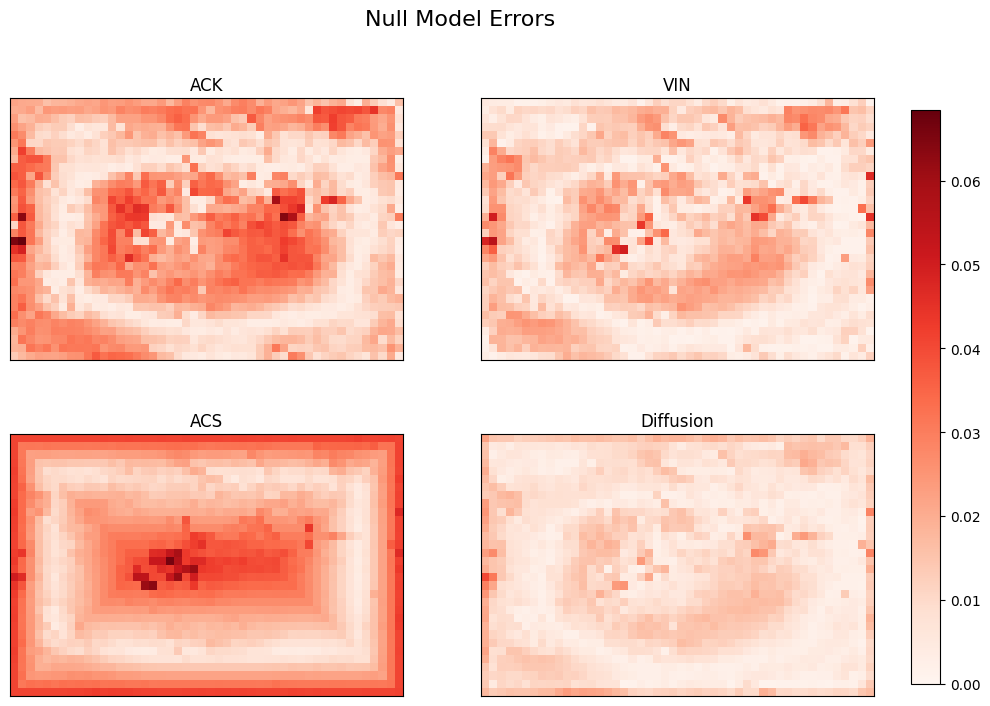

In [61]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
cmax = np.max(NullE_K.mean(axis=2))
K = axs[0,0].imshow(NullE_K.mean(axis=2),cmap='Reds',vmin=0,vmax=cmax); axs[0,0].set_title("ACK")
N = axs[0,1].imshow(NullE_N.mean(axis=2),cmap='Reds',vmin=0,vmax=cmax); axs[0,1].set_title("VIN")
S = axs[1,0].imshow(NullE_S.mean(axis=2),cmap='Reds',vmin=0,vmax=cmax); axs[1,0].set_title("ACS")
D = axs[1,1].imshow(NullE_D.mean(axis=2),cmap='Reds',vmin=0,vmax=cmax); axs[1,1].set_title("Diffusion")

for ax in axs.ravel():
    ax.set_xticks([]);ax.set_yticks([])
    
fig.colorbar(K,ax = axs,fraction=0.046*.67, pad=0.04)
fig.suptitle("Null Model Errors",fontsize=16)
plt.show()

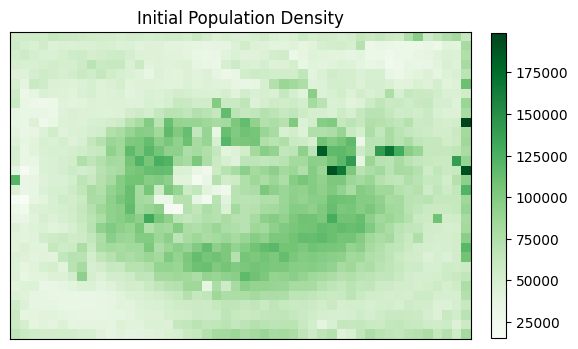

In [8]:
fig, axs = plt.subplots()
N = axs.imshow(N_K[1,0,:,:],cmap='Greens'); axs.set_title("Initial Population Density")

axs.set_xticks([]);axs.set_yticks([])
    
fig.colorbar(K,ax = axs,fraction=0.046*.67, pad=0.04)
plt.show()

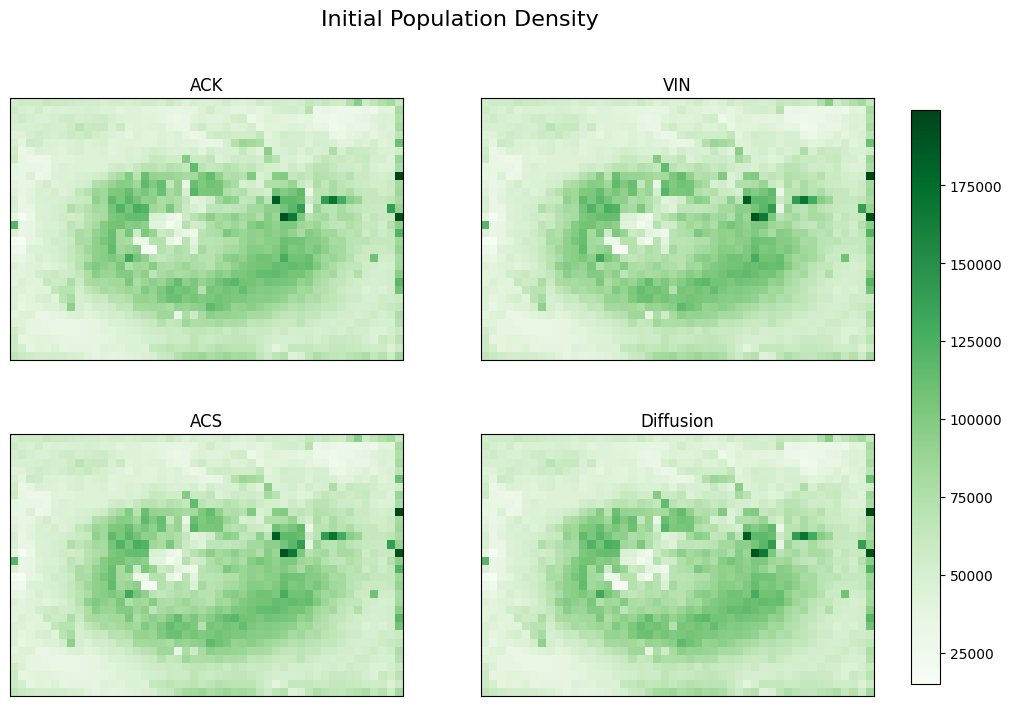

In [6]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
#cmax = np.max(NullE_K.mean(axis=2))
K = axs[0,0].imshow(N_K[1,0,:,:],cmap='Greens'); axs[0,0].set_title("ACK")
N = axs[0,1].imshow(N_N[1,0,:,:],cmap='Greens'); axs[0,1].set_title("VIN")
S = axs[1,0].imshow(N_S[1,0,:,:],cmap='Greens'); axs[1,0].set_title("ACS")
D = axs[1,1].imshow(N_D[1,0,:,:],cmap='Greens'); axs[1,1].set_title("Diffusion")

for ax in axs.ravel():
    ax.set_xticks([]);ax.set_yticks([])
    
fig.colorbar(K,ax = axs,fraction=0.046*.67, pad=0.04)
fig.suptitle("Initial Population Density",fontsize=16)
plt.show()

In [6]:
# TimePoints,Rows,Columns,Features
ACK_D = np.zeros((250,32,48,20))
ACN_D = np.zeros((250,32,48,19))
ACS_D = np.zeros((400,32,48,23))
DIFF_D = np.zeros((400,32,48,23))

# Growth Curves

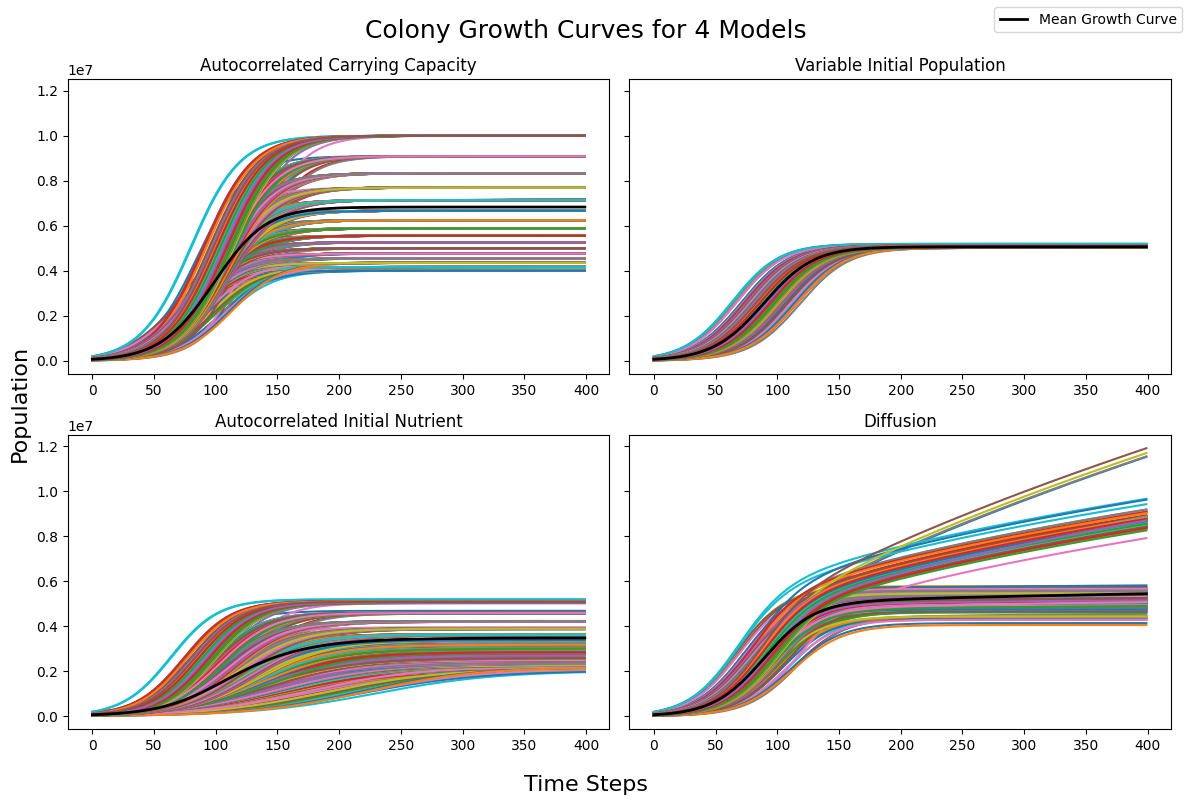

In [7]:
fig, axs = plt.subplots(2,2,figsize=(12,8),sharey=True)

for i in range(N_K.shape[2]):
    for j in range(N_K.shape[3]):
        axs[0][0].plot(N_K[1,:,i,j]); axs[0][0].set_title("Autocorrelated Carrying Capacity")
        axs[0][1].plot(N_N[1,:,i,j]); axs[0][1].set_title("Variable Initial Population")
        axs[1][0].plot(N_S[1,:,i,j]); axs[1][0].set_title("Autocorrelated Initial Nutrient")
        axs[1][1].plot(N_D[1,:,i,j]); axs[1][1].set_title("Diffusion")

# plot mean curves
axs[0][0].plot(np.mean(N_K[1,:,:,:],axis=(1,2)),c='k',lw=2,label='Mean Growth Curve')
axs[0][1].plot(np.mean(N_N[1,:,:,:],axis=(1,2)),c='k',lw=2)
axs[1][0].plot(np.mean(N_S[1,:,:,:],axis=(1,2)),c='k',lw=2)
axs[1][1].plot(np.mean(N_D[1,:,:,:],axis=(1,2)),c='k',lw=2)

fig.supylabel("Population",fontsize=16)
fig.supxlabel("Time Steps",fontsize=16)
fig.suptitle("Colony Growth Curves for 4 Models",fontsize=18)
fig.legend()
fig.tight_layout()
plt.show()